<a href="https://colab.research.google.com/github/raplima/2020_cores_auto/blob/master/detectron2_cores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectron2 for object detection with core images

This project is built using [detectron2](https://github.com/facebookresearch/detectron2).  
This notebook :
* Trains a detectron2 model on a dataset of interpreted core images
* Computes the performance statistics
* Runs inference on images with the newly trained detectron2 model

You can see a more complete example of detectron2 usage in their [notebook](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5).


# Install detectron2
As shown [here](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5).

In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

# install detectron2:
#!pip install detectron2==0.1.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
     |████████████████████████████████| 276kB 2.5MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=6e621ea7d03ce05bf9f8d5a37d87e4a5823d4ebfba6d1f58702cd998ad2576fe
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-4x_2oo24
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-4x_2oo24
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-lin

In [2]:
# download, decompress the data
!gdown https://drive.google.com/uc?id=1LJfHTdmPC_o-b_5dI2uVdhU5_FKGpBTJ
!unzip cores.zip > /dev/null

# download class json from github
!wget https://raw.githubusercontent.com/raplima/2020_cores_auto/master/data/classes.json
!mv classes.json cores

Downloading...
From: https://drive.google.com/uc?id=1LJfHTdmPC_o-b_5dI2uVdhU5_FKGpBTJ
To: /content/cores.zip
296MB [00:04, 61.2MB/s]
--2020-06-19 15:03:10--  https://raw.githubusercontent.com/raplima/2020_cores_auto/master/data/classes.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 318 [text/plain]
Saving to: ‘classes.json’

classes.json        100%[===================>]     318  --.-KB/s    in 0s      

2020-06-19 15:03:10 (16.2 MB/s) - ‘classes.json’ saved [318/318]



In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


# import the remaining of the necessary modules
import os
import json

from detectron2.structures import BoxMode
# to train
from detectron2.engine import DefaultTrainer
# to evaluate
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Train on a custom dataset

In this section, we will train an existing detectron2 model on a custom dataset in a new format.

We use the dataset with interpreted lithofacies.
We'll train a new segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have the "new" category. We'll be able to recognize this new class in a few minutes.

Register the dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [2]:
def get_data_dicts(img_dir):
    # get the classes:
    json_file = os.path.join(img_dir, "classes.json")
    with open(json_file) as f:
        ann_classes = json.load(f)
    # transform the dictionary into a list 
    classes=sorted([it for _, it in ann_classes.items()])

    json_file = os.path.join(img_dir, "vanhorn_hawkins_payne_musselman_final_json.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for anno in annos:
            #assert not anno["region_attributes"]
            region = anno['region_attributes']
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(ann_classes[region['lithofacies']]),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [3]:
path_train = 'cores'
path_val = 'cores'
dataset_tag = 'well_'
json_file = os.path.join(path_train, "classes.json")
with open(json_file) as f:
    classes = json.load(f)

for d in ["train", "val"]:
  DatasetCatalog.register(dataset_tag + d, lambda d=d: get_data_dicts(path_train))
  MetadataCatalog.get(dataset_tag + d).set(thing_classes=sorted([it for _, it in classes.items()]))

train_metadata = MetadataCatalog.get(f"{dataset_tag}train")
val_metadata = MetadataCatalog.get(f"{dataset_tag}val")
print('ok')

ok


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



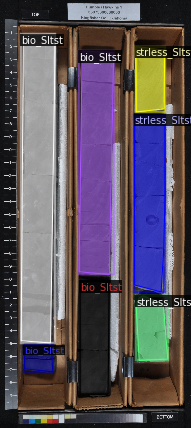

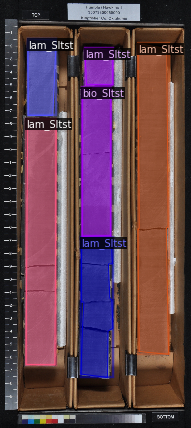

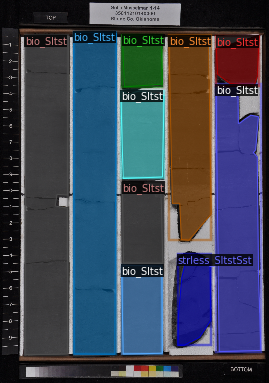

In [4]:
dataset_dicts = get_data_dicts(path_train)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.1)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Train

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the new dataset. 


In [5]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (f"{dataset_tag}train",)
cfg.DATASETS.TEST = (f"{dataset_tag}val",)
cfg.DATALOADER.NUM_WORKERS = 2
# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001  
cfg.SOLVER.MAX_ITER = 1500    

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)   # number of classes

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

# print GPU information
!nvidia-smi

[06/19 15:40:46 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (8, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (8,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (28, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (28,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (7, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (7,) in the model!


Fri Jun 19 15:41:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    74W / 149W |    564MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
trainer.train()

[06/19 15:41:23 d2.engine.train_loop]: Starting training from iteration 0
[06/19 15:41:56 d2.utils.events]:  eta: 0:39:34  iter: 19  total_loss: 3.858  loss_cls: 2.140  loss_box_reg: 0.301  loss_mask: 0.694  loss_rpn_cls: 0.413  loss_rpn_loc: 0.256  time: 1.6140  data_time: 0.0728  lr: 0.000020  max_mem: 2764M
[06/19 15:42:29 d2.utils.events]:  eta: 0:40:13  iter: 39  total_loss: 2.988  loss_cls: 1.535  loss_box_reg: 0.392  loss_mask: 0.677  loss_rpn_cls: 0.170  loss_rpn_loc: 0.170  time: 1.6406  data_time: 0.0091  lr: 0.000040  max_mem: 2851M
[06/19 15:43:02 d2.utils.events]:  eta: 0:39:32  iter: 59  total_loss: 1.968  loss_cls: 0.713  loss_box_reg: 0.427  loss_mask: 0.617  loss_rpn_cls: 0.045  loss_rpn_loc: 0.171  time: 1.6531  data_time: 0.0064  lr: 0.000060  max_mem: 2851M
[06/19 15:43:37 d2.utils.events]:  eta: 0:39:05  iter: 79  total_loss: 1.948  loss_cls: 0.662  loss_box_reg: 0.515  loss_mask: 0.538  loss_rpn_cls: 0.038  loss_rpn_loc: 0.165  time: 1.6681  data_time: 0.0069  lr:

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output
# images can be exported as SVG for further edits before publication

<IPython.core.display.Javascript object>

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the validation dataset. First, let's create a predictor using the model we just trained:



In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = (f"{path_val}_val", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

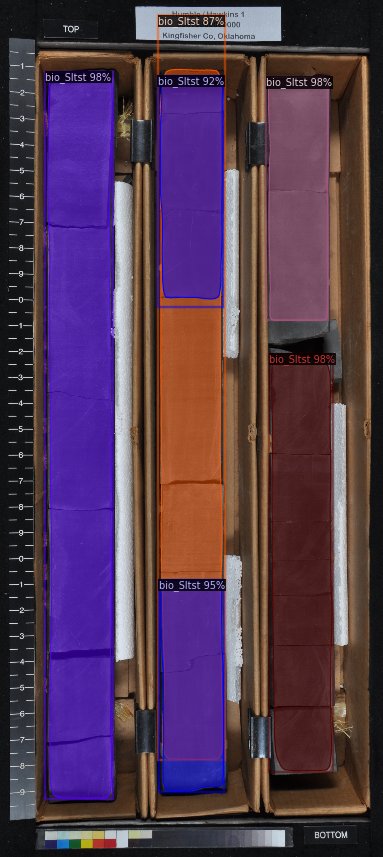

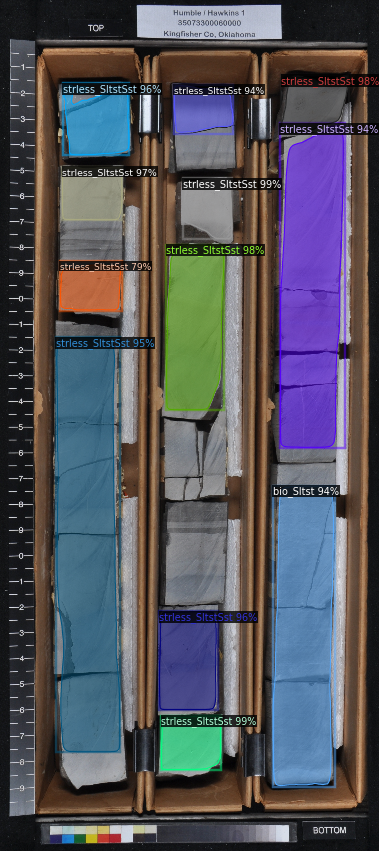

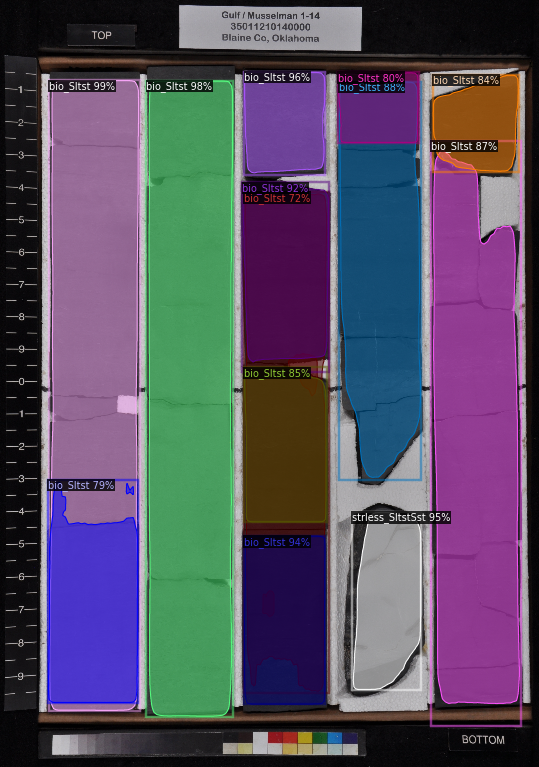

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_data_dicts(path_val)
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata, 
                   scale=0.2, 
                   instance_mode=ColorMode.SEGMENTATION   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])
    cv2.imwrite(f'{d["file_name"]}_predicted.png', v.get_image()[:, :, ::-1])

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70%. Not bad!

In [ ]:
evaluator = COCOEvaluator(f"{dataset_tag}val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, f"{dataset_tag}val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [06/18 18:38:50 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'well_val'. Trying to convert it to COCO format ...
[06/18 18:38:50 d2.data.datasets.coco]: Converting annotations of dataset 'well_val' to COCO format ...)
[06/18 18:39:10 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[06/18 18:39:11 d2.data.datasets.coco]: Conversion finished, #images: 71, #annotations: 662
[06/18 18:39:11 d2.data.datasets.coco]: Caching COCO format annotations at './output/well_val_coco_format.json' ...
[06/18 18:39:32 d2.data.common]: Serializing 71 elements to byte tensors and concatenating them all ...
[06/18 18:39:32 d2.data.common]: Serialized dataset takes 0.17 MiB
[06/18 18:39:32 d2.evaluation.evaluator]: Start inference on 71 images
[06/18 18:40:57 d2.evaluation.evaluator]: Inference done 11/71. 0.6305 s / img. ETA=0:07:05
[06/18 18:41:06 d2.evaluation.evaluator]: Inference done 12/71. 0.6347 s / img. ETA=0:07:09
[06/18 18:41:13 d2.evalu

OrderedDict([('bbox',
              {'AP': 63.563980594688275,
               'AP-bio_Sltst': 75.68257069574221,
               'AP-brec_Cht': 72.62033816208692,
               'AP-glauc_Sltst': 73.50463617790349,
               'AP-lam_Sltst': 42.03792466865529,
               'AP-skel_WkstPkst': 67.16127587288076,
               'AP-strless_SltstSst': 76.05063346419585,
               'AP-xlam_Sltst': 37.89048512135336,
               'AP50': 82.3591180866779,
               'AP75': 77.72730298043916,
               'APl': 63.563980594688275,
               'APm': nan,
               'APs': nan}),
             ('segm',
              {'AP': 65.31596406204736,
               'AP-bio_Sltst': 76.6714034095587,
               'AP-brec_Cht': 76.07846416428973,
               'AP-glauc_Sltst': 78.5124941065535,
               'AP-lam_Sltst': 42.56856180233071,
               'AP-skel_WkstPkst': 73.51138000012625,
               'AP-strless_SltstSst': 77.90658388195881,
               'AP-xl

In [ ]:
  # donwload images with results
from google.colab import files
res = os.listdir(path_val)
for r in res:
    if 'predicted' in r:
        print(r)
        files.download(os.path.join(path_val, r))

Box 8 Depths 10035-45.JPG_predicted.png


MessageError: ignored

In [ ]:
# delete folders
!rm -r output
!rm -r cores
!rm cores.zip

rm: cannot remove 'output': No such file or directory
rm: cannot remove 'cores.zip': No such file or directory


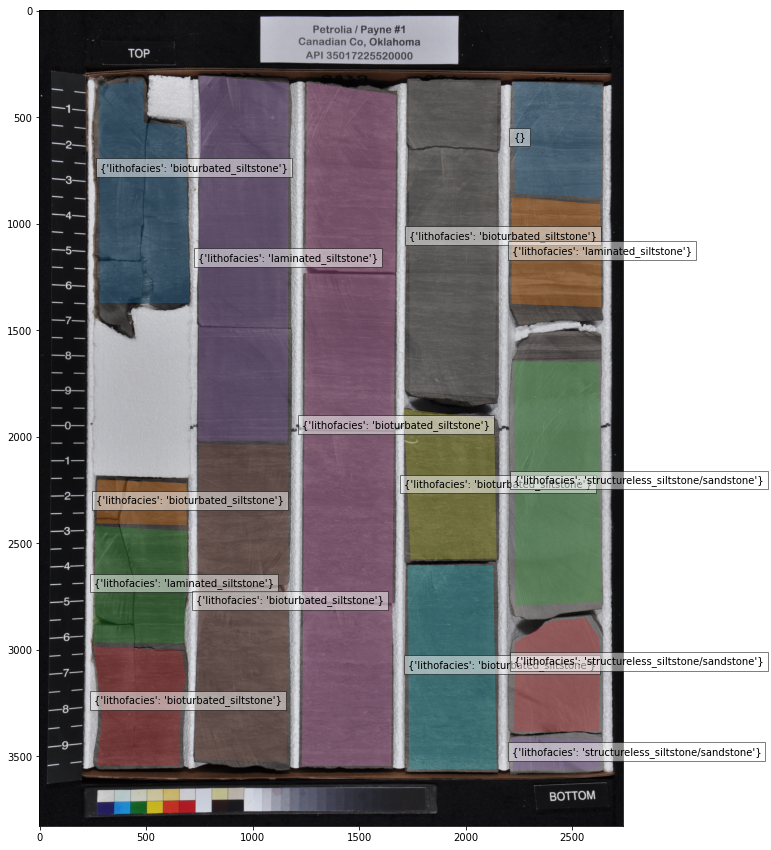

In [ ]:
import json
json_file = "vanhorn hawkins payne musselman robots_vanhorn_hawkins_payne_musselman_final_json.json"
with open(json_file) as f:
    json_dict = json.load(f)

img_in = 'cores/Box 5  Depths 8935-8945 (Dry).JPG'

img = np.rot90(np.rot90(np.rot90(plt.imread(img_in))))  
img_dict = json_dict['Box 5  Depths 8935-8945 (Dry).JPG4888028']  

img_dict['regions'][0]['region_attributes'].keys()

fig, ax = plt.subplots(1, figsize=(12,15))
ax.imshow(img)

for bx in img_dict['regions']:
    ax.fill(bx['shape_attributes']['all_points_x'], bx['shape_attributes']['all_points_y'], alpha=0.3)
    ax.text(np.min(bx['shape_attributes']['all_points_x']), np.mean(bx['shape_attributes']['all_points_y']), 
        s=bx['region_attributes'], 
        bbox=dict(facecolor='white', alpha=0.5))

In [ ]:
print(cfg.dump())  # print formatted configs

CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: true
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST:
  - cores_val
  TRAIN:
  - well_train
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: false
    SIZE:
    - 0.9
    - 0.9
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN:
  - 640
  - 672
  - 704
  - 736
  - 768
  - 800
  MIN_SIZE_TRAIN_SAMPLING: choice
MODEL:
  ANCHOR_GENERATOR:
    ANGLES:
    - - -90
      - 0
      - 90
    ASPECT_RATIOS:
    - - 0.5
      - 1.0
      - 2.0
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES:
    - - 32
    - - 64
    - - 128
    - - 256
    - - 512
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  F